# Jetsoncar Resnet V1

Tensorflow 2.0, all in notebook, optimized with RT

In [20]:
import tensorflow as tf
print(tf.__version__)
tf.config.experimental.list_physical_devices('GPU') # If device does not show and using conda env with tensorflow-gpu then try restarting computer

2.1.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

(480, 848, 3)


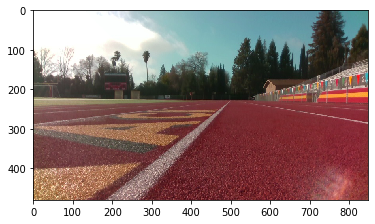

In [21]:
# verify the image data directory
import os
data_directory = "/media/michael/BigMemory/datasets/jetsoncar/training_data/data/dataset"
os.listdir(data_directory)[:10]

import matplotlib.pyplot as plt
img = plt.imread(os.path.join(data_directory + "/color_images", os.listdir(data_directory + "/color_images")[0]))
print(img.shape)
plt.imshow(img)

## Create the datagenerator and augmentation framework

(240, 640, 3)
(480, 848, 3)
(1, 240, 640, 3)


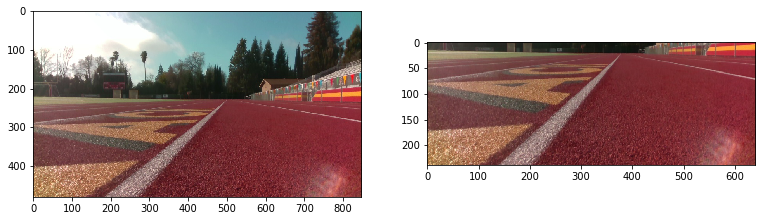

In [22]:
# Include the custom utils.py and perform tests
import importlib
utils = importlib.import_module('utils')
import numpy as np

print(utils.INPUT_SHAPE)

img = utils.load_image(os.path.join(data_directory, 'color_images'),os.listdir(data_directory + "/color_images")[0])
print(img.shape)

fig = plt.figure(figsize=(20,20))
fig.add_subplot(1, 3, 1)
plt.imshow(img)

img, _ = utils.preprocess_data(last_color_image=img)
print(img.shape)

fig.add_subplot(1, 3, 2)
plt.imshow(np.squeeze(img))

plt.show()

Number of data samples is 17214


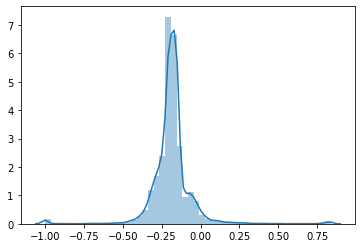

In [23]:
# Load the steering angles and image paths from labels.csv
import csv, random
import seaborn as sns

# these will be 2D arrays where each row represents a dataset
x = [] # images
y = [] # steering
z = [] # speed
with open(os.path.join(data_directory, "tags.csv")) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # print(row['Time_stamp'] + ".jpg", row['Steering_angle'])
        if not float(row['raw_speed']) == 0:
            x.append(row['time_stamp'] + ".jpg",)  # get image path
            y.append(float(row['raw_steering']),) # get steering value
            z.append(float(row['raw_speed']))

print("Number of data samples is " + str(len(y)))

data = list(zip(x,y))
random.shuffle(data)
x,y = zip(*data)

# plot of steering angle distribution without correction
sns.distplot(y)

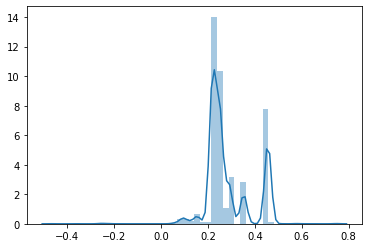

In [24]:
# plot of speed distribution
sns.distplot(z)

In [25]:
# Split the training data
validation_split = 0.2
train_x = x[0:int(len(x)*(1.0-validation_split))]
train_y = y[0:int(len(y)*(1.0-validation_split))]
print("Training data shape: " + str(len(train_x)))
test_x = x[int(len(x)*(1.0-validation_split)):]
test_y = y[int(len(y)*(1.0-validation_split)):]
print("Validation data shape: " + str(len(test_x)) + "\n")

Training data shape: 13771
Validation data shape: 3443



(32, 240, 640, 3)
-0.10832571074488011


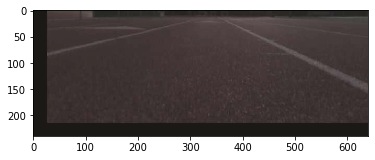

In [26]:
# Define and test batch generator
def batch_generator(data_dir, image_paths, steering_angles, batch_size, is_training):
    """
    Generate training image give image paths and associated steering angles
    """
    images = np.empty([batch_size, utils.IMAGE_HEIGHT, utils.IMAGE_WIDTH, utils.IMAGE_CHANNELS])
    steers = np.empty(batch_size)
    while True:
        i = 0
        for index in np.random.permutation(len(image_paths)):
            img = image_paths[index]
            steering_angle = steering_angles[index]
            # argumentation
            if is_training and np.random.rand() < 0.8:
                image, steering_angle = utils.augument(data_dir, os.path.join("color_images",img), steering_angle)
            else:
                image, _ = utils.preprocess_data(utils.load_image(data_dir, os.path.join("color_images",img)))
            # add the image and steering angle to the batch
            images[i] = image
            steers[i] = steering_angle
            i += 1
            if i == batch_size:
                break
        yield images, steers
        
train_generator = batch_generator(data_directory, train_x, train_y, 32, True)
validation_generator = batch_generator(data_directory, test_x, test_y, 32, False)

train_image = next(train_generator) # returns tuple with steering and throttle
print(train_image[0].shape)
print(train_image[1][0])
plt.imshow(train_image[0][0])

## Define the model and start training

In [27]:
# This is a pretrained resnet50 with custom head for detection
resnet = tf.keras.applications.ResNet50V2(include_top=False, input_tensor=tf.keras.layers.Input(shape=(240, 640, 3))) # takes in image of 224x224
resnet_head = tf.keras.models.Model(inputs=resnet.input, outputs=resnet.layers[-46].output) # get output to (14x14x256)
# don't retrain weights from imagenet
# for layer in resnet_head.layers:
#     layer.trainable = False 
    
# resnet_head.summary()

# custom tail
x = tf.keras.layers.Conv2D(64, (3,3), kernel_initializer='lecun_uniform', padding='same')(resnet_head.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('elu')(x)
x = tf.keras.layers.MaxPool2D((2,2))(x)
x = tf.keras.layers.Conv2D(32, (3,3), kernel_initializer='lecun_uniform', padding='same')(resnet_head.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('elu')(x)
x = tf.keras.layers.MaxPool2D((2,2))(x)
x = tf.keras.layers.Conv2D(16, (3,3), kernel_initializer='lecun_uniform', padding='same')(resnet_head.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('elu')(x)
x = tf.keras.layers.MaxPool2D((2,2))(x)
x = tf.keras.layers.Conv2D(8, (3,3), kernel_initializer='lecun_uniform', padding='same')(resnet_head.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('elu')(x)
x = tf.keras.layers.MaxPool2D((2,2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(10, activation='elu')(x)
out = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.models.Model(inputs=resnet_head.input, outputs=out)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 240, 640, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 246, 646, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 120, 320, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 122, 322, 64) 0           conv1_conv[0][0]                 
___________________________________________________________________________________________

In [28]:
import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
print("To view tensorboard please run `tensorboard --logdir logs/fit` in the code directory from the terminal with deeplearning env active")

checkpoint = tf.keras.callbacks.ModelCheckpoint('rosey_v2.{epoch:03d}-{val_loss:.2f}.h5', # filepath = working directory/
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='auto')

model.fit_generator(train_generator,
                    steps_per_epoch=100, 
                    epochs=20,
                    validation_data=validation_generator,
                    validation_steps=1,
                   callbacks=[tensorboard_callback, checkpoint])

To view tensorboard please run `tensorboard --logdir logs/fit` in the code directory from the terminal with deeplearning env active
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 1 steps
Epoch 1/20
  1/100 [..............................] - ETA: 20:13

KeyError: 'val_loss'

In [17]:
# Test the model
image, steering = next(train_generator)
print(steering)
print(model.predict(image))
print("")

image, steering = next(validation_generator)
print(steering)
print(model.predict(image))

[-0.07579999 -0.06791745  0.34416015 -0.15735557 -0.17658998  0.28847728
 -0.18137634 -0.31899998 -0.23558489  0.02785583 -0.01457344 -0.05583983
  0.15811298  0.16095588  0.17598007 -0.30359998  0.15033502 -0.32851522
 -0.19180001 -0.25079929  0.20675636  0.22017684 -0.15380052 -0.47200917
  0.41834434 -0.20699999 -0.05658487  0.33289024  0.07517898 -0.30499998
 -0.07560001 -0.1834086 ]
[[-0.21742064]
 [ 0.03161988]
 [ 0.2750771 ]
 [-0.16780752]
 [-0.21987048]
 [-0.00587225]
 [-0.05176141]
 [-0.23996317]
 [ 0.02314058]
 [-0.20436761]
 [ 0.07513502]
 [-0.00574243]
 [ 0.20512843]
 [-0.08488294]
 [ 0.06414735]
 [-0.23026705]
 [ 0.23474067]
 [-0.28741685]
 [-0.10852048]
 [-0.24618068]
 [ 0.17068914]
 [ 0.2518867 ]
 [-0.070436  ]
 [ 0.06837636]
 [ 0.03775704]
 [-0.05125373]
 [-0.15106815]
 [ 0.44502074]
 [ 0.09578112]
 [-0.17483196]
 [-0.10670036]
 [-0.07917967]]

[-0.00899999 -0.27059999 -0.1918     -0.1636     -0.161      -0.26499999
 -0.16160001 -0.16160001 -0.20259999 -0.30059999 -0.20

## Save the model as tensor RT and export to Jetson format

In [29]:
# Load the model that you would like converted to RT
model_path = 'model.h5'
export_path = "/home/michael/Desktop/model"

import shutil
if not os.path.isdir(export_path):
    os.mkdir(export_path)
else:
    response = input("Do you want to delete existing export_path directory? y/n")
    if response == 'y':
        shutil.rmtree(export_path)
        os.mkdir(export_path)

loaded_model = tf.keras.models.load_model(model_path)

shutil.copy("./utils.py", os.path.join(export_path, "utils.py"))
shutil.copy("./notes.txt", os.path.join(export_path, "notes.txt"))
shutil.copy("./config.yaml", os.path.join(export_path, "config.yaml"))
# Save as tf saved_model (faster than h5)
tf.saved_model.save(loaded_model, export_path)

Do you want to delete existing export_path directory? y/n y


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/michael/Desktop/model/assets


In [30]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS
conversion_params = conversion_params._replace(max_workspace_size_bytes=(1 << 32))
conversion_params = conversion_params._replace(precision_mode="INT8")
conversion_params = conversion_params._replace(maximum_cached_engines=100)
conversion_params = conversion_params._replace(use_calibration=True)

def my_calibration_input_fn():
    for i in range(20):
        image, _ = utils.preprocess_data(utils.load_image(data_directory, os.path.join("color_images",x[i])))
        yield image.astype(np.float32),

converter = trt.TrtGraphConverterV2(input_saved_model_dir=export_path,conversion_params=conversion_params)

gen = my_calibration_input_fn()

converter.convert(calibration_input_fn=my_calibration_input_fn)
converter.build(my_calibration_input_fn)

if not os.path.isdir(os.path.join(export_path, "rt")):
    os.mkdir(os.path.join(export_path, "rt"))
    
converter.save(os.path.join(export_path, "rt"))

INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)


TypeError: join() argument must be str or bytes, not 'Tensor'

In [31]:
# Test normal saved model
saved_model = tf.saved_model.load(export_path) # normal saved model

image, _ = next(validation_generator)

import time
output = saved_model(image.astype(np.float32)) # load once to get more accurate representation of speed
start = time.time()
output = saved_model(image.astype(np.float32))
stop = time.time()
print("inference time: " + str(stop - start))
print("Output: %.20f"%output[8,0])

inference time: 0.15479755401611328
Output: -0.27822759747505187988


In [32]:
# Test TRT optimized saved model
saved_model = tf.saved_model.load(os.path.join(export_path, "rt")) # normal saved model


image, _ = next(validation_generator)

import time
output = saved_model(image.astype(np.float32)) # load once to get more accurate representation of speed
start = time.time()
output = saved_model(image.astype(np.float32))
stop = time.time()
print("inference time: " + str(stop - start))
print("Output: %.20f"%output[8,0])

OSError: SavedModel file does not exist at: /home/michael/Desktop/model/rt/{saved_model.pbtxt|saved_model.pb}

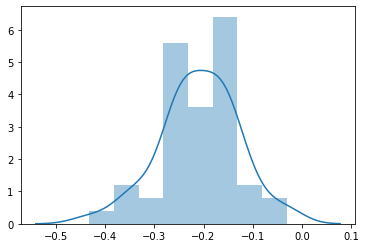

In [33]:
# Run many samples through and save distribution 
validation_generator = batch_generator(data_directory, test_x, test_y, 32, False)
test = []
for i in range(50):
    img, _ = next(validation_generator)
    test.append(saved_model(img.astype(np.float32))[0][0])
    print(str(i), end="\r")
sns.distplot(test)